In [1]:
import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
import seaborn as sns
import pandas as pd
from labproject.metrics.wasserstein_sinkhorn import sinkhorn_loss,sinkhorn_algorithm
from labproject.metrics.wasserstein_kuhn import kuhn_transport
from labproject.metrics.sliced_wasserstein import sliced_wasserstein_distance
from labproject.metrics.MMD_torch import compute_rbf_mmd,median_heuristic
from labproject.data import get_distribution
from labproject.utils import set_seed
from dataclasses import dataclass
from torch.distributions import MultivariateNormal, Categorical
set_seed(0)



0

In [2]:
class MO2G:
    def __init__(self):
        self.means = torch.tensor(
            [
                [-3.0,1],
                [3, -1],

            ]
        )
        self.covariances = torch.tensor(
            [
                [[1.0, 0], [0, 1.0]],
                [[1.0, 0], [0, 1.0]]

            ]
        )
        self.weights = torch.tensor([0.2,0.8])

        # Create a list of 2D Gaussian distributions
        self.gaussians = [
            MultivariateNormal(mean, covariance)
            for mean, covariance in zip(self.means, self.covariances)
        ]

    def sample(self, sample_shape):
        if isinstance(sample_shape, int):
            sample_shape = (sample_shape,)
        # Sample from the mixture
        categorical = Categorical(self.weights)
        sample_indices = categorical.sample(sample_shape)
        return torch.stack([self.gaussians[i].sample() for i in sample_indices])

    def log_prob(self, input):
        probs = torch.stack([g.log_prob(input).exp() for g in self.gaussians])
        probs = probs.T * self.weights
        return torch.sum(probs, dim=1).log()



In [3]:
#Base distribution
from torch.distributions.multivariate_normal import MultivariateNormal
toy_data = get_distribution("toy_2d")
MOG = toy_data()
MOG = MO2G()
num_samples = 1000
mixture_samples =MOG.sample(num_samples)
mixture_samples = torch.tensor(mixture_samples, dtype=torch.float32)

/tmp/ipykernel_293012/39751654.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mixture_samples = torch.tensor(mixture_samples, dtype=torch.float32)


In [4]:
plt.style.use("../../matplotlibrc")


In [5]:
class Gauss(nn.Module):
    def __init__(self,dim):
        super(Gauss, self).__init__()
        self.dim = dim
        self.mean = nn.Parameter(torch.zeros(dim))
        self.scale_tril = nn.Parameter(torch.eye(dim))
        self.G = torch.distributions.MultivariateNormal(self.mean, scale_tril=self.scale_tril)

    def sample(self,size):
        return self.G.rsample((size,))
    def cov(self):
        return self.G.covariance_matrix.detach()

    def log_prob(self, value):
        return self.G.log_prob(value)


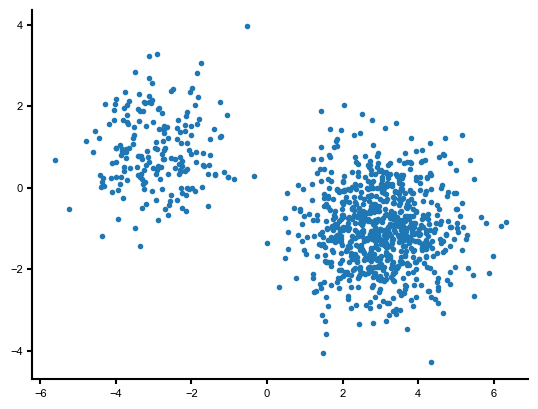

In [6]:
plt.scatter(mixture_samples[:, 0], mixture_samples[:, 1], label="Mixture of Gaussians")
covar = torch.cov(mixture_samples.T)
#plt.gca().set_box_aspect(1)


#make axis square

#plt.xlim()

In [7]:
def c2st_target(samples1, samples2, density1, density2):
    r"""Computes optimal C2ST and resulting classification cross-entropy loss
    for optimization
    """
    density_ratios1 = torch.stack([density1.log_prob(samples1), density2.log_prob(samples1)], dim=-1)
    density_ratios2 = torch.stack([density1.log_prob(samples2), density2.log_prob(samples2)], dim=-1)
    probs = torch.cat([density_ratios1, density_ratios2], dim=0)
    labels = torch.cat([torch.zeros(len(samples1)), torch.ones(len(samples2))], dim=0).long()
    loss = -nn.functional.cross_entropy(probs, labels)
    with torch.no_grad():
        c2st = (sum(density_ratios1[:, 0] >= density_ratios1[:, 1]) + sum(density_ratios2[:, 0] < density_ratios2[:, 1])) / (len(samples1) + len(samples2))
    return loss, c2st

In [10]:
gauss_model_C2ST = Gauss(2)

model_toy_opt = torch.optim.Adam(gauss_model_C2ST.parameters(), lr=0.01)

In [11]:
n_iters =1500
num_samples = 1000

for epoch in range(n_iters):
    model_toy_opt.zero_grad()

    model_samples = gauss_model_C2ST.sample(num_samples)
    toy_samples = MOG.sample(num_samples)

    cent_loss, true_c2st = c2st_target(model_samples, toy_samples, gauss_model_C2ST, MOG)
    # c2st_loss = torch.mean(torch.square(preds - 0.5))
    if epoch % 5 == 0:
        print("Iter: {}     loss: {}     c2st: {}".format(epoch, cent_loss.item(), true_c2st.item()))
    cent_loss.backward()
    model_toy_opt.step()

Iter: 0     loss: -0.18932674825191498     c2st: 0.9244999885559082
Iter: 5     loss: -0.199568510055542     c2st: 0.921500027179718
Iter: 10     loss: -0.17485348880290985     c2st: 0.9304999709129333
Iter: 15     loss: -0.18035486340522766     c2st: 0.9259999990463257
Iter: 20     loss: -0.1936042457818985     c2st: 0.921500027179718
Iter: 25     loss: -0.19968226552009583     c2st: 0.9204999804496765
Iter: 30     loss: -0.1947559118270874     c2st: 0.9269999861717224
Iter: 35     loss: -0.22649028897285461     c2st: 0.9110000133514404
Iter: 40     loss: -0.22107742726802826     c2st: 0.9125000238418579
Iter: 45     loss: -0.24077168107032776     c2st: 0.906000018119812
Iter: 50     loss: -0.21032653748989105     c2st: 0.9200000166893005
Iter: 55     loss: -0.21348099410533905     c2st: 0.9045000076293945
Iter: 60     loss: -0.22673237323760986     c2st: 0.9049999713897705
Iter: 65     loss: -0.24222654104232788     c2st: 0.906000018119812
Iter: 70     loss: -0.22405926883220673     

ValueError: Expected value argument (Tensor of shape (1000, 2)) to be within the support (IndependentConstraint(Real(), 1)) of the distribution MultivariateNormal(loc: torch.Size([2]), scale_tril: torch.Size([2, 2])), but found invalid values:
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]], grad_fn=<AddBackward0>)

In [12]:
# MMD
gauss_model_MMD = Gauss(dim=2)
with torch.no_grad():
    samples = gauss_model_MMD.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)
    bandwidth = median_heuristic(mixture_samples, uniform_samples)
    print("bandwidth: ", bandwidth)


bandwidth:  tensor(2.3120)


In [13]:

bandwidth = 1
optimizer = torch.optim.Adam(gauss_model_MMD.parameters(), lr=0.01)
gauss_model_MMD.train()

for epoch in range(n_iters):
    gauss_model_MMD.zero_grad()
    samples = gauss_model_MMD.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)    #print(samples)
    loss = compute_rbf_mmd(samples, uniform_samples, bandwidth=bandwidth)
    print("Iter: {}     loss: {}".format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

gauss_model_MMD.eval()



Iter: 0     loss: 0.42863646149635315
Iter: 1     loss: 0.43528854846954346
Iter: 2     loss: 0.42734232544898987
Iter: 3     loss: 0.4048576056957245
Iter: 4     loss: 0.42388707399368286
Iter: 5     loss: 0.40420693159103394
Iter: 6     loss: 0.3881773054599762
Iter: 7     loss: 0.37610143423080444
Iter: 8     loss: 0.4030715823173523
Iter: 9     loss: 0.38276249170303345
Iter: 10     loss: 0.3736810088157654
Iter: 11     loss: 0.3686324656009674
Iter: 12     loss: 0.37369304895401
Iter: 13     loss: 0.3634757995605469
Iter: 14     loss: 0.3465002179145813
Iter: 15     loss: 0.3390219807624817
Iter: 16     loss: 0.3277679681777954
Iter: 17     loss: 0.3238801062107086
Iter: 18     loss: 0.3103933334350586
Iter: 19     loss: 0.31488335132598877
Iter: 20     loss: 0.3093177080154419
Iter: 21     loss: 0.3131977915763855
Iter: 22     loss: 0.31944170594215393
Iter: 23     loss: 0.2942793369293213
Iter: 24     loss: 0.29933276772499084
Iter: 25     loss: 0.2975691556930542
Iter: 26     l

Gauss()

In [14]:
# WS

gauss_model_WS = Gauss(dim=2)
optimizer = torch.optim.Adam(gauss_model_WS.parameters(), lr=0.01)
gauss_model_WS.train()
for epoch in range(n_iters):
    gauss_model_WS.zero_grad()
    samples = gauss_model_WS.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)    #print(samples)
    loss = sliced_wasserstein_distance(samples, uniform_samples)#, bandwidth=bandwidth)
    print("Iter: {}     loss: {}".format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

gauss_model_WS.eval()



Iter: 0     loss: 1.869416356086731


Iter: 1     loss: 1.7726036310195923
Iter: 2     loss: 1.8247215747833252
Iter: 3     loss: 1.579911708831787
Iter: 4     loss: 1.9026764631271362
Iter: 5     loss: 1.6013213396072388
Iter: 6     loss: 1.8345041275024414
Iter: 7     loss: 1.7116317749023438
Iter: 8     loss: 1.6673530340194702
Iter: 9     loss: 1.7692811489105225
Iter: 10     loss: 1.6430226564407349
Iter: 11     loss: 1.6488488912582397
Iter: 12     loss: 1.6663192510604858
Iter: 13     loss: 1.5525658130645752
Iter: 14     loss: 1.808214783668518
Iter: 15     loss: 1.7604916095733643
Iter: 16     loss: 1.7533960342407227
Iter: 17     loss: 1.5733642578125
Iter: 18     loss: 1.6710468530654907
Iter: 19     loss: 1.5791010856628418
Iter: 20     loss: 1.5227957963943481
Iter: 21     loss: 1.5817310810089111
Iter: 22     loss: 1.657675862312317
Iter: 23     loss: 1.592205286026001
Iter: 24     loss: 1.5284669399261475
Iter: 25     loss: 1.598633050918579
Iter: 26     loss: 1.432592511177063
Iter: 27     loss: 1.588122248

Gauss()

In [15]:
#FROM: https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
from matplotlib.patches import Ellipse

def plot_cov_ellipse(cov, pos, nstd=[1,2], ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    for std in nstd:
    # Width and height are "full" widths, not radius
        width, height = 2 * std * np.sqrt(vals)
        print(pos,width, height,theta)
        ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

        ax.add_artist(ellip)
    return ellip

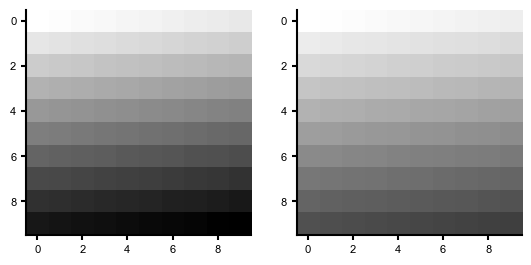

In [16]:
# FROM: https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
import matplotlib.colors as colors


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('gist_yarg')
new_cmap = truncate_colormap(cmap, 0, 0.75)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

[ 1.8063684 -0.5605345] 1.2383002 0.5315173 161.1063
[ 1.8063684 -0.5605345] 3.7149005 1.594552 161.1063
[ 1.8063684 -0.5605345] 7.429801 3.189104 161.1063
[ 1.8063684 -0.5605345] 12.383002 5.315173 161.1063
[ 3.0046332 -1.0091757] 0.59562194 0.5934992 179.35492
[ 3.0046332 -1.0091757] 1.7868658 1.7804976 179.35492
[ 3.0046332 -1.0091757] 3.5737317 3.560995 179.35492
[ 3.0046332 -1.0091757] 5.9562197 5.934992 179.35492
[nan nan] nan nan nan
[nan nan] nan nan nan
[nan nan] nan nan nan
[nan nan] nan nan nan


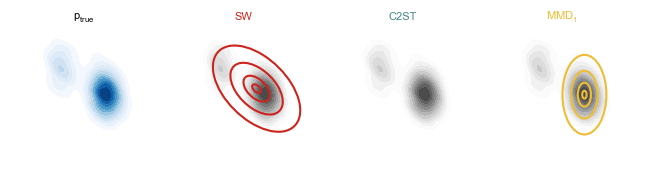

In [17]:
num_samples = 10000
#SWD_samples = gauss_model_WS.sample(num_samples).detach().numpy()
#MMD_samples = gauss_model_MMD.sample(num_samples).detach().numpy()
#C2ST_samples = gauss_model_C2ST.sample(num_samples).detach().numpy()

# Create a dataframe for the mixture samples
unif_df = pd.DataFrame({'x': uniform_samples[:, 0], 'y': uniform_samples[:, 1]})

# Create a dataframe for the SWD mixture samples
#SWD_df = pd.DataFrame({'x': SWD_samples[:, 0], 'y': SWD_samples[:, 1]})
#MMD_df = pd.DataFrame({'x': MMD_samples[:, 0], 'y': MMD_samples[:, 1]})
#C2ST_df = pd.DataFrame({'x': C2ST_samples[:, 0], 'y': MMD_samples[:, 1]})

# Plot the probability contours
fig,axs = plt.subplots(1,4, figsize = (6.5,3))
sns.kdeplot(ax=axs[0],data=unif_df, x='x', y='y',cmap="Blues", fill=True,levels=12)#, thresh=.1,)#, color="black",alpha=0.75, levels=5)

alpha_bg=1
sns.kdeplot(ax=axs[1],data=unif_df, x='x', y='y', fill=True,cmap=new_cmap,alpha=alpha_bg, levels=12)
sns.kdeplot(ax=axs[2],data=unif_df, x='x', y='y', fill=True,cmap=new_cmap,alpha=alpha_bg, levels=12)
sns.kdeplot(ax=axs[3],data=unif_df, x='x', y='y', fill=True,cmap=new_cmap,alpha=alpha_bg, levels=12)

#x, y = np.mgrid[-10:10:.1, -10:10:.1]
#z =torch.exp(gauss_model_WS.log_prob(data)).detach().numpy()
##axs[1].contour(x, y, z,colors ='#cc241d')#), cmap='coolwarm',fill=False)
##z =torch.exp(gauss_model_MMD.log_prob(data)).detach().numpy()
#axs[2].contour(x, y, z,colors ='#eebd35')#), cmap='coolwarm',fill=False)
#z =torch.exp(gauss_model_C2ST.log_prob(data)).detach().numpy()
#axs[3].contour(x, y, z,colors ="#458588")#), cmap='coolwarm',fill=False)
std_plot = [np.sqrt(.25),np.sqrt(.5),np.sqrt(1),np.sqrt(2)]
std_plot=[.25,.75,1.5,2.5]
plot_cov_ellipse(gauss_model_WS.cov().detach().numpy(),gauss_model_WS.mean.detach().numpy(),
                 nstd = std_plot ,ax=axs[1],edgecolor='#cc241d', lw=1.5, facecolor='none')
#axs[1].scatter(gauss_model_WS.mean.detach().numpy()[0],gauss_model_WS.mean.detach().numpy()[1],
#               color='#cc241d',s=1.5)
plot_cov_ellipse(gauss_model_MMD.cov().detach().numpy(),gauss_model_MMD.mean.detach().numpy(),
                 nstd = std_plot ,ax=axs[3],edgecolor='#eebd35', lw=1.5, facecolor='none')
plot_cov_ellipse(gauss_model_C2ST.cov().detach().numpy(),gauss_model_C2ST.mean.detach().numpy(),
                 nstd = std_plot ,ax=axs[2],edgecolor='#458588', lw=1.5, facecolor='none')

#sns.kdeplot(ax=axs[1],data=SWD_df, x='x', y='y', fill=False,cmap ="Reds",levels=7)#,color="#cc241d",alpha=.5, levels=5)
#sns.kdeplot(ax=axs[2],data=MMD_df, x='x', y='y', fill=False,cmap='Wistia',levels=7)#color="#eebd35",alpha=.5, levels=5)
#sns.kdeplot(ax=axs[3],data=C2ST_df, x='x', y='y', fill=False,cmap='Blues',levels=7)#color="#eebd35",alpha=.5, levels=5)
#color_dict = {"SW": "#cc241d", "MMD": "#eebd35", "C2ST": "#458588", "FID": "#8ec07c"}
#ax.scatter(uniform_samples[:20, 0], uniform_samples[:20, 1], color="black",zorder=10)
#ax.scatter(SWD_samples[:20, 0], SWD_samples[:20, 1], color="coral",zorder=10)
for ax in axs:
    ax.spines[['left', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xlim(-8,5)
    ax.set_xlim(-10,10)

    ax.set_ylim(-7,4)
    #make square subplots 
    ax.set_box_aspect(1)
axs[0].set_title(r"$p_{true}$")
axs[1].set_title("SW",color ='#cc241d')
axs[3].set_title(r"$MMD_1$",color ='#eebd35')
axs[2].set_title("C2ST",color ="#458588")

fig.tight_layout()
plt.savefig("mode.pdf")

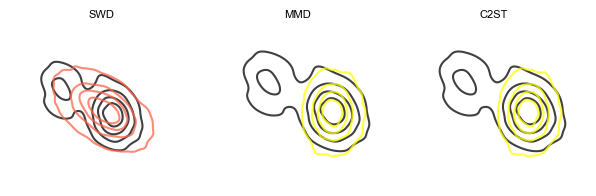

In [18]:
SWD_samples = gauss_model_WS.sample(num_samples).detach().numpy()
MMD_samples = gauss_model_MMD.sample(num_samples).detach().numpy()
C2ST_samples = gauss_model_C2ST.sample(num_samples).detach().numpy()

# Create a dataframe for the mixture samples
unif_df = pd.DataFrame({'x': uniform_samples[:, 0], 'y': uniform_samples[:, 1]})

# Create a dataframe for the SWD mixture samples
SWD_df = pd.DataFrame({'x': SWD_samples[:, 0], 'y': SWD_samples[:, 1]})
MMD_df = pd.DataFrame({'x': MMD_samples[:, 0], 'y': MMD_samples[:, 1]})
C2ST_df = pd.DataFrame({'x': MMD_samples[:, 0], 'y': MMD_samples[:, 1]})

# Plot the probability contours
fig,axs = plt.subplots(1,3, figsize = (6,2))
sns.kdeplot(ax=axs[0],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[1],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[2],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)

sns.kdeplot(ax=axs[0],data=SWD_df, x='x', y='y', fill=False, color="tomato",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[1],data=MMD_df, x='x', y='y', fill=False, color="yellow",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[2],data=C2ST_df, x='x', y='y', fill=False, color="yellow",alpha=0.75, levels=5)

#ax.set_xlim(-1.5, 1.5)
#ax.set_ylim(-1.5, 1.5)
#ax.scatter(uniform_samples[:20, 0], uniform_samples[:20, 1], color="black",zorder=10)
#ax.scatter(SWD_samples[:20, 0], SWD_samples[:20, 1], color="coral",zorder=10)
for ax in axs:
    ax.spines[['left', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
axs[0].set_title("SWD")
axs[1].set_title("MMD")
axs[2].set_title("C2ST")

fig.tight_layout()
